# Batch UCB


In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold
from sklearn_extra.cluster import KMedoids

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *
from codes.batch_ucb import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Update 13/Nov/2020** Generate recommendation for round 2 (with partial replicates for round 0 and 1)

In [2]:
Path = '../../data/Results_Microplate_partialTrue_normTrue_roundRep_formatSeq_logTrue.csv'

known_df = pd.read_csv(Path)
known_df.head()

,idx,RBS,Name,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,...,Replicates,Plate,Round,Rep7,Rep8,Rep9,RBS6,Pred Mean,Pred Std,Pred UCB
0,648.0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,2.482263,2.555338,2.358414,3.102950,2.999178,2.316265,2.635735,...,"1,2,3,4,5,6",First_Plate,0,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
1,4096.0,CTTAAGAAGGAGATATACAT,RBS_1by1_1,1.592779,1.694296,1.798210,1.850738,2.381356,1.996343,1.885620,...,"1,2,3,4,5,6",First_Plate,0,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
2,4097.0,GTTAAGAAGGAGATATACAT,RBS_1by1_2,0.626302,0.774704,0.947196,0.418233,0.532036,0.733023,0.671916,...,"1,2,3,4,5,6",First_Plate,0,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
3,4098.0,ATTAAGAAGGAGATATACAT,RBS_1by1_3,1.696364,1.917735,1.568130,1.600853,1.803056,1.260720,1.641143,...,"1,2,3,4,5,6",First_Plate,0,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
4,4099.0,TCTAAGAAGGAGATATACAT,RBS_1by1_4,1.582321,2.118618,1.417531,2.014216,1.831391,2.186262,1.858390,...,"1,2,3,4,5,6",First_Plate,0,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN


In [3]:
# known_df = known_df[known_df['Group'] != 'bps_noncore']
# known_df.reset_index(inplace=True, drop=True)
# known_df['RBS'] = known_df['RBS6']
# known_df

## Conclusion of pipeline

- Data pre-processing: run codes/data_generating.py
    - log transform 
    - z-score normalisation for each replicate (zero mean and unit variance)
- Kernel: codes/kernels_for_GPK.py
    - weighted degree kernel with shift
    - normalisation: centering; unit variance; normalisation over the whole (train + test) kernel
    - l = 6 (maximum substring length)
    - s = 1 (shift)
    - sigma0 = 1 (signal std)
- Regression: codes/regression.py
    - Gaussian Process Regression
    - train on samples (multi-label) from first round result, i.e. train shape:  (1055, 20)
    - predict on all design space (4 * 6) except known sequences, i.e. test shape:  (3961, 20)
    - alpha = 2
- Recommendation: codes/batch_ucb.py
    - batch UCB (GP-BUCB)
    - beta = 2
    - recommendation size = 90

In [4]:
rec_size = 90
l = 6
s = 1
beta = 2
alpha = 2
sigma_0 = 1
kernel_name = 'WD_Kernel_Shift'
embedding = 'label'
kernel_norm_flag = False
centering_flag = False
unit_norm_flag = False

## Top n recommendations

return seuqneces with top n ucb score. 

In [5]:
top_n = Top_n_ucb(known_df, kernel_name=kernel_name, l=l, s=s, sigma_0=sigma_0,
                 embedding=embedding, alpha=alpha, rec_size=rec_size, beta=beta, 
                 kernel_norm_flag=kernel_norm_flag, centering_flag = centering_flag, unit_norm_flag=unit_norm_flag)

In [6]:
unknown_df = top_n.generate_design_space()
# unknown_df.to_csv('unknown_df.csv')
unknown_df.shape

(3873, 2)

In [7]:
top_n_rec_df = top_n.run_experiment()

X train shape:  (1589, 20)
X test shape:  (3873, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
gp_reg pred
finish reg


(array([   3.,   17.,   76.,  209.,  434.,  839., 1098.,  897.,  284.,
          16.]),
 array([0.27277316, 0.29505377, 0.31733437, 0.33961498, 0.36189559,
        0.38417619, 0.4064568 , 0.42873741, 0.45101801, 0.47329862,
        0.49557922]),
 <a list of 10 Patch objects>)

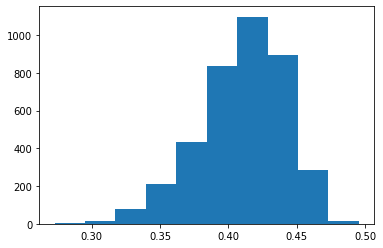

In [8]:
plt.hist(top_n.df_design['pred std'])

(array([ 2.,  0.,  6., 10., 12., 11., 13., 15., 17.,  4.]),
 array([0.27277316, 0.2889787 , 0.30518423, 0.32138976, 0.3375953 ,
        0.35380083, 0.37000637, 0.3862119 , 0.40241743, 0.41862297,
        0.4348285 ]),
 <a list of 10 Patch objects>)

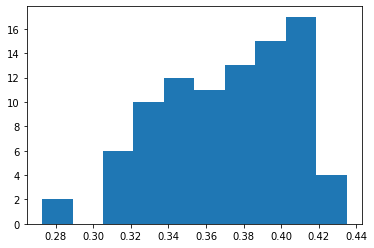

In [9]:
plt.hist(top_n_rec_df['pred std'])

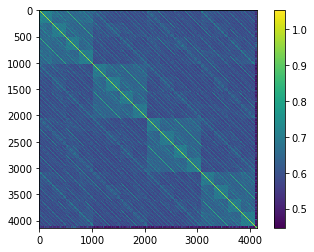

In [10]:
kernel_matrix = top_n.gpr.wd_kernel_instance.kernel_all_normalised
plt.imshow(kernel_matrix)
plt.colorbar()

## GP-BUCB

Desautels et al. 2014 Algorithm 2
http://jmlr.org/papers/volume15/desautels14a/desautels14a.pdf

In [11]:
gpbucb = GP_BUCB(known_df, kernel_name=kernel_name, l=l, s=s,sigma_0=sigma_0,
                 embedding=embedding, alpha=alpha, rec_size=rec_size, beta=beta, 
                 kernel_norm_flag=kernel_norm_flag, centering_flag = centering_flag, unit_norm_flag=unit_norm_flag)

In [12]:
gpbucb_rec_df = gpbucb.run_experiment()

X train shape:  (1589, 20)
X test shape:  (3873, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (266, 26)
X train shape:  (1590, 20)
X test shape:  (3872, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (267, 26)
X train shape:  (1591, 20)
X test shape:  (3871, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_Fa

wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (287, 26)
X train shape:  (1611, 20)
X test shape:  (3851, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (288, 26)
X train shape:  (1612, 20)
X test shape:  (3850, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_Fal

wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (308, 26)
X train shape:  (1632, 20)
X test shape:  (3830, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (309, 26)
X train shape:  (1633, 20)
X test shape:  (3829, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (310, 26)
X train shape:  (1634, 20)


wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (329, 26)
X train shape:  (1653, 20)
X test shape:  (3809, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (330, 26)
X train shape:  (1654, 20)
X test shape:  (3808, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (331, 26)
X train shape:  (1655, 20)
X test shape:  (3807, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_

gp_reg pred
finish reg
train size  (350, 26)
X train shape:  (1674, 20)
X test shape:  (3788, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (351, 26)
X train shape:  (1675, 20)
X test shape:  (3787, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (352, 26)
X train shape:  (1676, 20)
X test shape:  (3786, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
finish creating kernel ins

## Recommendation results

In [13]:
gpbucb_rec_df

,index,AVERAGE,Group,Name,PERC,Plate,Pred Mean,Pred Std,Pred UCB,RBS,...,Replicates,Round,STD,Usable,idx,train_test,label,pred mean,pred std,ucb
0,1358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGCGGGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.822533,0.344822,1.512177
1,1294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGGGGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.811983,0.339855,1.491693
2,1292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGGAGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.817632,0.318726,1.455085
3,1354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGCGAGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.663584,0.359563,1.382709
4,1342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGCAGGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.572508,0.400999,1.374505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,1349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGCATATATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.191655,0.382655,0.956964
86,2060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGACACGAGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.147895,0.403094,0.954083
87,1308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGCATTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.266363,0.343650,0.953663
88,1301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGGTATATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.180394,0.383930,0.948255


In [14]:
top_n_rec_df

,index,AVERAGE,Group,Name,PERC,Plate,Pred Mean,Pred Std,Pred UCB,RBS,...,Replicates,Round,STD,Usable,idx,train_test,label,pred mean,pred std,ucb
1623,1358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGCGGGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.822533,0.344822,1.512177
1559,1294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGGGGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.811983,0.340668,1.493320
1557,1292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGGAGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.817632,0.320279,1.458191
1619,1354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGCGAGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.663584,0.362428,1.388439
1607,1342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGCAGGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.572508,0.403042,1.378592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3489,3224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGATGGGATTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.363388,0.311992,0.987372
2361,2096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGACACTGGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.233502,0.376769,0.987040
1315,1050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGAGAGGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.186434,0.398731,0.983897
1566,1301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGGTATATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.180394,0.400345,0.981084


In [15]:
top_n_rec_df.index

Int64Index([1623, 1559, 1557, 1619, 1607, 1518, 1549, 1591, 1651, 2500, 3491,
            1622, 3477, 2263, 2251, 2743,  590,  587, 1681, 1638, 1650, 1649,
            1558, 1660, 1656, 1850, 1514, 1561, 2020, 3231, 3243, 2008, 1782,
            1569, 1677, 2329, 2024, 1560, 2267, 1620, 1621, 1544,  650, 1632,
            1636, 1634, 2143, 2575, 1711, 1665, 3279, 2140, 1795, 1624, 1617,
             619, 2820, 1556, 1565, 1847, 3310, 1652, 1628, 3707, 1606, 2455,
            1835, 1393, 1575, 2250,  821, 2742,  680, 3247, 1609, 1658, 2755,
            1614, 1517,  682, 2847, 2325, 2696, 1618, 2056, 3489, 2361, 1315,
            1566, 2544],
           dtype='int64')

### Similarity between recommendations

characterized by the same kernel used for prediction.

Text(0.5, 1.0, 'GP_BUCB hist')

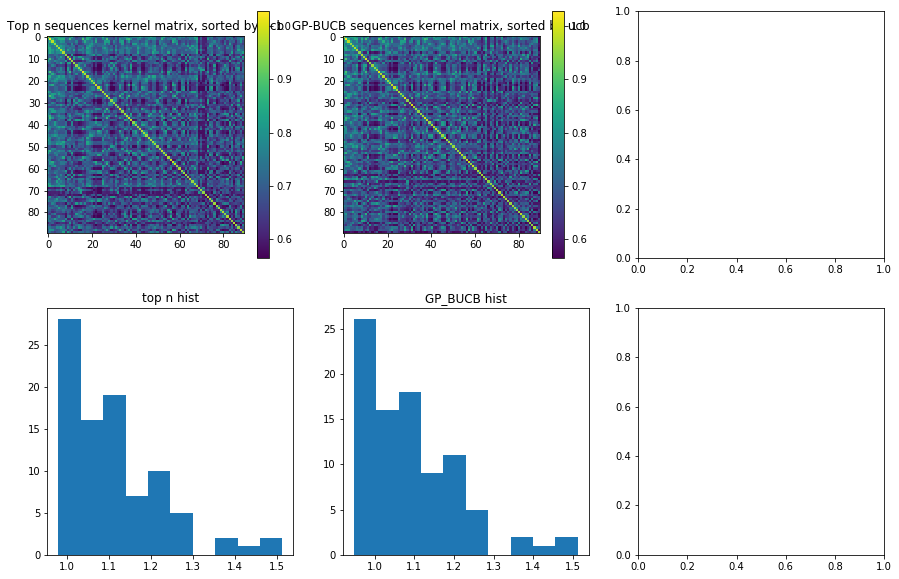

In [20]:
num_rows = 2
num_cols = 3

wd_kernel = WD_Shift_Kernel
fig,a = plt.subplots(num_rows, num_cols, figsize = (15,10))

wd_kernel.INIT_FLAG = False
im = a[0][0].imshow(top_n.gpr.wd_kernel_instance.__call__(np.asarray(top_n_rec_df['RBS'])), cmap = 'viridis')
fig.colorbar(im, ax =a[0][0])
a[0][0].set_title('Top n sequences kernel matrix, sorted by ucb')

wd_kernel.INIT_FLAG = False
im = a[0][1].imshow(gpbucb.gpr.wd_kernel_instance.__call__(np.asarray(gpbucb_rec_df['RBS'])), cmap = 'viridis')
fig.colorbar(im, ax =a[0][1])
a[0][1].set_title('GP-BUCB sequences kernel matrix, sorted by ucb')

# wd_kernel.INIT_FLAG = False
# all_features = np.concatenate((np.asarray(top_n_rec_df['RBS']), np.asarray(gpbucb_rec_df['RBS'])), axis = 0)
# im = a[0][2].imshow(wd_kernel(l=6, features = all_features).kernel_all_normalised, cmap = 'viridis')
# fig.colorbar(im, ax =a[0][2])
# a[0][2].set_title('Top n + GP-BUCB')

im = a[1][0].hist(top_n_rec_df['ucb'])
a[1][0].set_title('top n hist')

im = a[1][1].hist(gpbucb_rec_df['ucb'])
a[1][1].set_title('GP_BUCB hist')

# im = a[1][2].hist(gpbucb_rec_df['ucb'])
# a[1][2].set_title('GP_BUCB hist')

In [ ]:
common_rec = set(top_n_rec_df['RBS']).intersection(set(gpbucb_rec_df['RBS']))
print('Number of intersection of recommendations: ', len(common_rec))

In [17]:
para_name = '_alpha' + str(alpha) + '_beta' + str(beta) + 'kernelNorm' + str(kernel_norm_flag)

with pd.ExcelWriter('batch_ucb.xlsx', engine="openpyxl", mode='a') as writer:
    top_n_rec_df.to_excel(writer, sheet_name = 'top_n_core_' + para_name)
    gpbucb_rec_df.to_excel(writer, sheet_name = 'gpbucb_core_' + para_name)

/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/openpyxl/workbook/child.py:102: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
